# Inference

In [4]:
import time
import datetime
import os
import ast
import sys
import pytz
import random
import shutil
# import splitfolders
import copy
from glob import glob
from tqdm import tqdm
from pprint import pprint

import warnings
import requests

import gc
import math
import numpy as np
import pandas as pd

import cv2
from PIL import Image
# import pydicom as pdm
import pickle
import yaml
import h5py
import json
import matplotlib.pyplot as plt
# import seaborn as sns

import albumentations as albu
import torch
import torch.nn as nn  
# import torchtuples as tt
from sklearn import metrics

import torchvision
import timm 
# import pretrainedmodels

In [20]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else: DEVICE = torch.device('cpu')
    
print('Using PyTorchversion:', torch.__version__, 'Device:', DEVICE)

Using PyTorchversion: 1.9.1+cu111 Device: cuda


In [42]:
WORK_DIR = './'
ANNOT_DIR = '/mnt/dataset/test/annotation/'
IMG_DIR = '/ainode/dataset/test/'
RGB_DIR = '/ainode/dataset/test/rgb/'
FLOW_DIR = '/ainode/dataset/test/flow/'

## Load Data

In [169]:
case_lst = [path.split('/')[-1].split('_')[0] for path in glob(ANNOT_DIR+'/*')]
case_lst.sort()

In [170]:
json_lst = []
for case_dir in case_lst:
    for path in glob(os.path.join(ANNOT_DIR, case_dir+'/*.json')):
        with open(path, 'r') as j:
            jsn = json.loads(j.read())
            json_lst.append(jsn)
len(json_lst)

40

In [171]:
final_df = pd.DataFrame()

for case_json in json_lst:
    event_df = pd.DataFrame.from_dict(case_json['Video_Info'])
    event_df['Case'] = [case_json['Case_Info']['Case_Number'] for i in range(len(event_df))]
    final_df = pd.concat([final_df, event_df])
    
len(final_df)
final_df.head()

,File_Name,File_Extension,Frame_Rate,Frame_Count,Start,End,Bit_Rate,Width,Height,Case
0,A2020-EM-01-0005_video_01.mp4,mp4,4.995,138163,2020/08/27 23:06:00.000,2020/08/28 06:47:00.000,289000.0,640,480,A2020-EM-01-0005
0,A2020-EM-01-0006_video_01.mp4,mp4,4.995,128415,2020/04/11 22:27:30.000,2020/04/12 05:35:58.243,279000.0,640,480,A2020-EM-01-0006
0,A2020-EM-01-0020_video_01.mp4,mp4,4.995,120331,2020/12/07 22:55:00.000,2020/12/08 05:36:30.000,283000.0,640,480,A2020-EM-01-0020
0,A2020-EM-01-0028_video_01.mp4,mp4,4.995,114636,2020/06/15 21:28:00.000,2020/06/16 03:50:30.000,268000.0,640,480,A2020-EM-01-0028
0,A2020-EM-01-0081_video_01.mp4,mp4,4.995,128123,2020/05/15 22:30:00.000,2020/05/16 05:37:30.000,285000.0,640,480,A2020-EM-01-0081


In [89]:
def frame2epoch(frameidx, fps): # image frame number (type 'int') to corresponding start epoch (type 'int')
    return int(frameidx//(30*fps)+1)

def epoch2frame(startepoch, fps): # start epoch (type 'int') to corresponding image frame start number, end number(type 'list')
    startframe = (startepoch-1)*fps*30
    return [int(startframe),int(startframe+fps*30)]

In [172]:
Epoch_Count = [frame2epoch(list(final_df['Frame_Count'])[idx], list(final_df['Frame_Rate'])[idx]) for idx in range(len(final_df))]

In [174]:
final_df['Epoch_Count'] = Epoch_Count

In [176]:
Frames = []
for idx in range(len(X)):
    fps = np.array(X['Frame_Rate'])[idx]
    startepoch = np.array(X['Epoch'])[idx]
    Frames.append(epoch2frame(startepoch+1, fps))

In [179]:
Epoch = []
Case = []
Frame_Rate = []
Frame_Count = []
Epoch_Count = []
for idx, epoch_count in enumerate(list(final_df['Epoch_Count'])):
    Epoch += list(range(epoch_count-1))
    Case += [list(final_df['Case'])[idx] for i in range(epoch_count-1)]
    Frame_Rate += [list(final_df['Frame_Rate'])[idx] for i in range(epoch_count-1)]
    Frame_Count += [list(final_df['Frame_Count'])[idx] for i in range(epoch_count-1)]
    Epoch_Count += [list(final_df['Epoch_Count'])[idx] for i in range(epoch_count-1)]

dict = {'Case': Case, 'Epoch': Epoch, 'Epoch_Count': Epoch_Count, 'Frame_Count': Frame_Count, 'Frame_Rate': Frame_Rate, 'Frames': Frames} 
X = pd.DataFrame(dict)

In [178]:
X

,Case,Epoch,Epoch_Count,Frame_Count,Frame_Rate,Frames
0,A2020-EM-01-0005,0,923,138163,4.995,"[0, 149]"
1,A2020-EM-01-0005,1,923,138163,4.995,"[149, 299]"
2,A2020-EM-01-0005,2,923,138163,4.995,"[299, 449]"
3,A2020-EM-01-0005,3,923,138163,4.995,"[449, 599]"
4,A2020-EM-01-0005,4,923,138163,4.995,"[599, 749]"
...,...,...,...,...,...,...
32883,A2021-EM-01-0163,929,935,139323,4.972,"[138569, 138718]"
32884,A2021-EM-01-0163,930,935,139323,4.972,"[138718, 138867]"
32885,A2021-EM-01-0163,931,935,139323,4.972,"[138867, 139017]"
32886,A2021-EM-01-0163,932,935,139323,4.972,"[139017, 139166]"


In [180]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import sklearn

In [194]:
class Dataset(BaseDataset):
    
    def __init__(
            self,  
            X,
            imgtype, # 'rgb','flow_x','flow_y'
            augmentation=None, 
            preprocessing=None,
    ):
        self.epochs = X['Epoch'].tolist()
        self.cases = X['Case']
        self.fps = X['Frame_Rate'].tolist()
        self.frames = X['Frames'].tolist()
        self.imgpaths = [f'{IMG_DIR}{imgtype[:4]}/{self.cases[idx]}_video_01/' for idx in range(len(self.epochs))]
        self.imgtype = imgtype
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        imgs_path = self.imgpaths[i] # 해당 케이스 이미지 다 들어가있는 디렉토리
        
        if 'flow' in self.imgtype:
            img_lst = glob(imgs_path+f'/{self.imgtype}*.jpg')
        else:
            img_lst = glob(imgs_path+'/img*.jpg')
        img_lst.sort()
        frames = self.frames[i]
#         frames = ast.literal_eval(self.frames[i])
        img_lst = img_lst[frames[0]:frames[1]] #img_lst[self.frames[i][0]:self.frames[i][0]+150]
        images = []
        
        for idx, path in enumerate(img_lst):
            if idx % 5 == 0:
                image = np.array(Image.open(path).resize((128,128)).convert('RGB'))
                image = np.transpose(image, (2, 0, 1))
                images.append(image)
        
        images = np.array(images)
        images = np.transpose(images, (1,0,2,3))
        images = torch.Tensor(images)
        
        return images

        
    def __len__(self):
        return len(self.epochs)

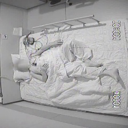

In [195]:
dataset = Dataset(X, 'rgb')
#                   augmentation = get_validation_augmentation()) #, preprocessing = get_preprocessing())
image = dataset[4]

np.array(image).shape
# dataset.cases, dataset.epochs
# np.unique(np.array(images[6]))
# Image.fromarray(np.array(image).astype('uint8'))
Image.fromarray(np.transpose(np.array(image).astype('uint8')[:,0,:,:], (2,1,0)))

## Load Model

In [196]:
resnet3d = torchvision.models.video.r3d_18(pretrained = True, progress = True)

In [197]:
# classifier layer output shape --> number of classes
CLASSES = 3

num_ftrs = resnet3d.fc.in_features
resnet3d.fc = nn.Linear(num_ftrs,CLASSES)
resnet3d.fc = nn.Sequential(resnet3d.fc, nn.Softmax(),)

In [198]:
LR =0.00005
optimizer = torch.optim.Adam(best_model.parameters(), lr = LR)

In [199]:
best_model = resnet3d

In [206]:
DIR = WORK_DIR + 'saved-models/'

weights = os.listdir(DIR)
weights.sort()
# val_losses = [filename.split('-')[2].split('val')[1] for filename in weights]
val_losses = [filename.split('-')[2].split('val')[1] for filename in weights] #[1:]]
best_weight = val_losses.index(min(val_losses))
# path = './saved_models/' + weights[best_weight]
path = DIR + weights[best_weight] #+1] # '.ipynb_checkpoints' 파일이 맨 앞에 있기 때문에 index가 하나씩 밀린다.

path = DIR+ 'model-epoch02-loss_val0.86-acc_val0.60.pt'


# best_model = torch.load(DIR+'model-epoch00-loss_val1.08-acc_val0.46.pt')
checkpoint = torch.load(path)
best_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
accuracy = checkpoint['accuracy']
# loss = checkpoint['loss']

best_model.eval()

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [207]:
test_dataset = Dataset(X,'rgb')

test_loader = DataLoader(test_dataset)

In [208]:
%%time
Xtest = next(iter(test_loader))
print('Xtest:', Xtest.size(), 'type:', Xtest.type())

Xtest: torch.Size([1, 3, 30, 128, 128]) type: torch.FloatTensor
CPU times: user 284 ms, sys: 24.3 ms, total: 308 ms
Wall time: 307 ms


In [ ]:
# true_labels = []
predicted_labels = []
predicted_values = []

best_model.eval()
best_model.to(DEVICE)

# test_loss = AverageMeter()
# test_acc = AverageMeter()

with torch.no_grad():                                                     # 모델을 평가하는 단계에서는 Gradient를 통해 parameter값이 update되는 현상을 방지하기 위해 'torch.no_grad()' 메서드를 이용해 Gradient의 흐름을 억제
    for image in tqdm(test_loader):
        image = image.to(DEVICE)
#         label = label.to(DEVICE)
        output = best_model(image)
#         loss = criterion(output, label)
        prediction = output.max(1, keepdim = True)[1]                     # output값 (prediction probability)가 가장 높은 index(class)로 예측
        
#         true_labels.append(label)
        predicted_labels.append(prediction)
        predicted_values.append(output)
        
#         test_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
#         test_loss.update(loss.item())
        
# test_loss.avg, test_acc.avg

 84%|████████▍ | 27568/32888 [2:28:52<29:06,  3.05it/s]  

In [216]:
with open('predicted_labels_rgb_v001.npy', 'wb') as f:
    np.save(f, np.array(predicted_labels))
    
with open('predicted_values_rgb_v001.npy', 'wb') as f:
    np.save(f, np.array(predicted_values))

In [217]:
X.to_csv('test_csv.csv', index = False)

In [215]:
len(predicted_values)

32888